# Stock forcasting using ARIMA model
### Mushfiqur Rahman [ Mushfiq ]
This project is created for learning purpose.Not recommended for trading. We have used Pyramid Auto Arima which runs multiple models and keep the one with best AIC value. 

In [183]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [184]:
import datetime
import pandas_datareader.data as web

In [185]:
start = datetime.datetime(2012, 1, 3)
end = datetime.date.today()
amzn = web.DataReader("AMZN", 'morningstar', start, end)

In [186]:
dfs = amzn.loc['AMZN']

In [187]:
dfs.head()

,Close,High,Low,Open,Volume
Date,,,,,
2012-01-03,179.03,179.475,175.550,176.35,5111970
2012-01-04,177.51,180.500,176.065,179.21,4206624
2012-01-05,177.61,178.250,174.050,175.94,3810496
2012-01-06,182.61,184.650,177.500,178.07,7010139
2012-01-09,178.56,184.370,177.000,182.76,5058542


In [188]:
dfs.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-02,1713.78,1713.890,1678.0600,1682.70,3185696
2018-07-03,1693.96,1725.000,1692.4800,1723.96,2177276
2018-07-04,1693.96,1693.960,1693.9600,1693.96,0
2018-07-05,1699.73,1710.690,1682.1501,1705.38,2983110
2018-07-06,1710.63,1715.268,1691.6700,1696.00,2650262


In [189]:
#dfs= dfs.iloc[:-1,:]

In [190]:
dfs.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2018-07-02,1713.78,1713.890,1678.0600,1682.70,3185696
2018-07-03,1693.96,1725.000,1692.4800,1723.96,2177276
2018-07-04,1693.96,1693.960,1693.9600,1693.96,0
2018-07-05,1699.73,1710.690,1682.1501,1705.38,2983110
2018-07-06,1710.63,1715.268,1691.6700,1696.00,2650262


In [191]:
timeseries = dfs['Close']

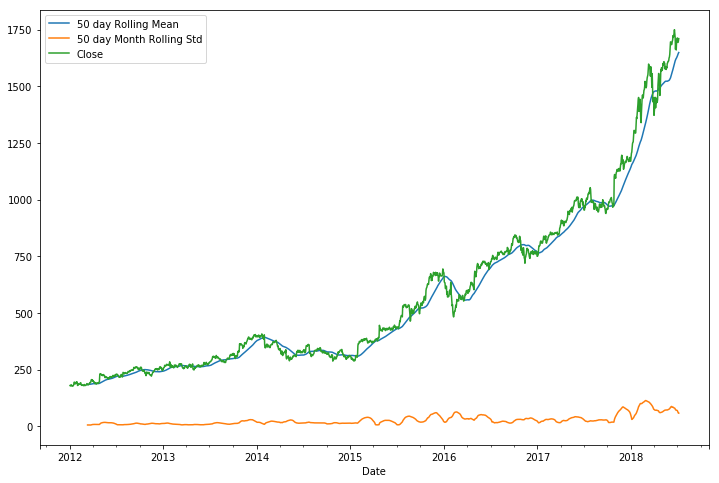

In [192]:
timeseries.rolling(50).mean().plot(label='50 day Rolling Mean', figsize = (12,8))
timeseries.rolling(50).std().plot(label='50 day Month Rolling Std')
timeseries.plot()
plt.legend()

## Decomposition

ETS decomposition allows us to see the individual parts!

<Figure size 432x288 with 0 Axes>

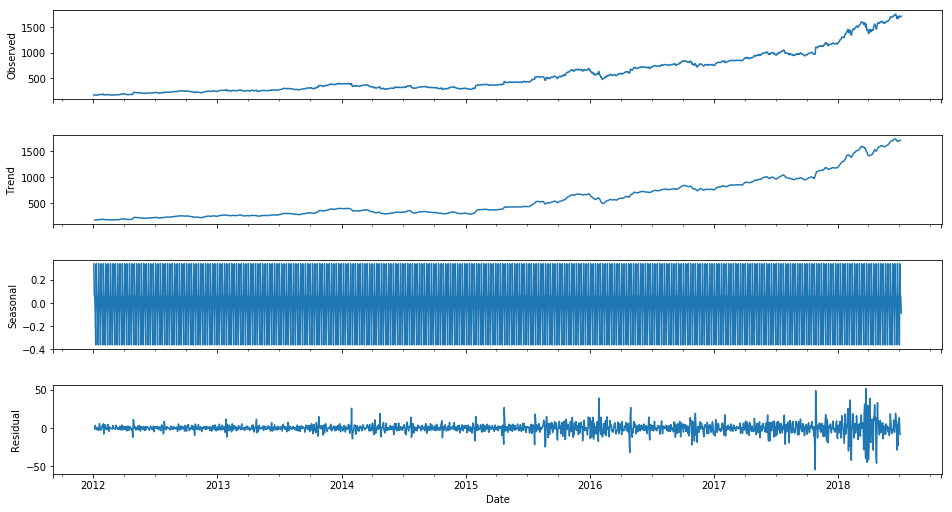

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeseries, freq = 5) 
# Check which number for frequecy shows nice seasonality decomposition to be able to observe the seasonality 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [194]:
from statsmodels.tsa.stattools import adfuller

In [195]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [196]:
adf_check(dfs['Close'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : 3.3088282886203975
p-value : 1.0
#Lags Used : 25
Number of Observations Used : 1673
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

** First Difference **

In [197]:
dfs['Stock First Difference'] = dfs['Close'] - dfs['Close'].shift(1)

In [198]:
adf_check(dfs['Stock First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.654759995883909
p-value : 5.003655639594357e-14
#Lags Used : 24
Number of Observations Used : 1673
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


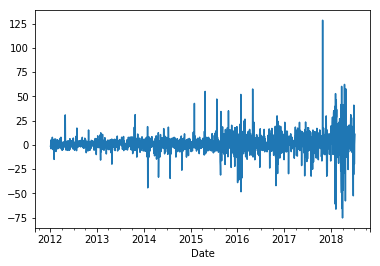

In [199]:
dfs['Stock First Difference'].plot()

** Seasonal Difference **

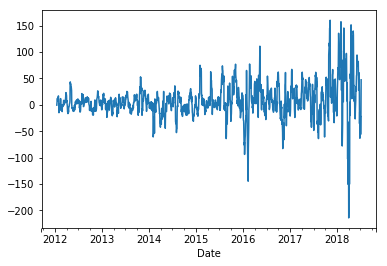

In [200]:
dfs['Seasonal Difference'] = dfs['Close'] - dfs['Close'].shift(9)
dfs['Seasonal Difference'].plot()

In [201]:
# Seasonal Difference by itself was not enough!
adf_check(dfs['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.4596637770801015
p-value : 5.395662304159731e-11
#Lags Used : 20
Number of Observations Used : 1669
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [202]:
from pyramid.arima import auto_arima

In [203]:
# choose the value of m same as the freq in ETS
stepwise_model = auto_arima(timeseries, start_p=1, start_q=1,
                           max_p=3, max_q=3,m=5,
                           start_P=0,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

13023.534017312957


In [204]:
timeseries.tail()

Date
2018-07-02    1713.78
2018-07-03    1693.96
2018-07-04    1693.96
2018-07-05    1699.73
2018-07-06    1710.63
Name: Close, dtype: float64

In [205]:
train = timeseries.loc[:'2018-05-31'] ## creating training data without the last month
test = timeseries.loc['2018-06-01':]  ## Will test the model using the last month data

In [206]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 2, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 5), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [207]:
future_forecast = stepwise_model.predict(n_periods=len(test))

In [208]:
print(future_forecast)

[1629.59183642 1633.96835686 1633.53016846 1635.24562818 1637.97693584
 1641.92091892 1642.03928438 1646.34512081 1648.78184049 1650.33836901
 1650.84363266 1654.6766929  1654.87292752 1656.69645472 1659.2877441
 1662.79548539 1663.41359198 1667.19540554 1669.56558731 1671.27120309
 1672.18301837 1675.60911528 1676.28819697 1678.19694554 1680.68604443
 1683.86781858]


In [209]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

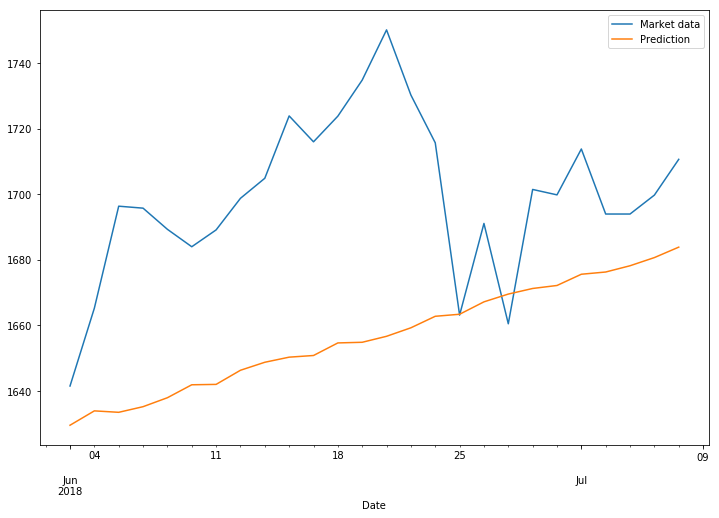

In [210]:
pd.concat([test,future_forecast],axis=1).plot(figsize= (12,8))
plt.legend(('Market data','Prediction' ))

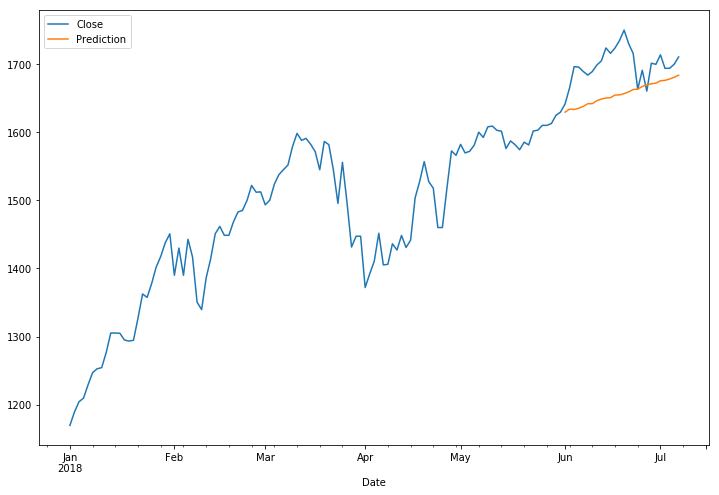

In [211]:
pd.concat([timeseries.loc['2018-01-01':],future_forecast],axis=1).plot(figsize= (12,8))

### Not too bad for our simple model. We could not predict the exterme volality but we got the trend. 

In [212]:
## Today is 5th July. 
## Let's predict the next 30 days  

In [213]:
from pandas.tseries.offsets import DateOffset

In [214]:
future_dates = [dfs.index[-1] + DateOffset(days=x) for x in range(0,30) ]

In [215]:
train2 = dfs['Close'] 

In [216]:
stepwise_model.fit(train2)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 2, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 5), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [217]:
forecast = stepwise_model.predict(n_periods=29)

In [218]:
print(forecast)

[1708.62914622 1713.30074264 1714.38610872 1718.79212269 1720.18138323
 1726.10358767 1726.09838181 1729.28337329 1729.51993585 1732.44056174
 1731.33530637 1735.50101889 1736.83424302 1740.79080572 1742.36471676
 1747.5195737  1747.99261579 1750.98595196 1751.65060684 1754.43575441
 1754.04112799 1757.81042159 1759.34261671 1762.9473373  1764.67029092
 1769.22219566 1770.0761965  1772.92132673 1773.92732183]


In [219]:
dfs.drop(['Stock First Difference', 'Seasonal Difference'], axis = 1, inplace=True)

In [220]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=dfs.columns)

In [221]:
forecast = pd.DataFrame(forecast,index = future_dates_df.index,columns=['Forecast'])

In [222]:
future_df = pd.concat([dfs,future_dates_df])

In [223]:
future_df.head()

,Close,High,Low,Open,Volume
2012-01-03,179.03,179.475,175.550,176.35,5111970
2012-01-04,177.51,180.500,176.065,179.21,4206624
2012-01-05,177.61,178.250,174.050,175.94,3810496
2012-01-06,182.61,184.650,177.500,178.07,7010139
2012-01-09,178.56,184.370,177.000,182.76,5058542


In [224]:
future_df.tail()

,Close,High,Low,Open,Volume
2018-07-31,NaN,NaN,NaN,NaN,NaN
2018-08-01,NaN,NaN,NaN,NaN,NaN
2018-08-02,NaN,NaN,NaN,NaN,NaN
2018-08-03,NaN,NaN,NaN,NaN,NaN
2018-08-04,NaN,NaN,NaN,NaN,NaN


In [225]:
len(dfs)

1699

In [226]:
future_df['forecast'] = forecast

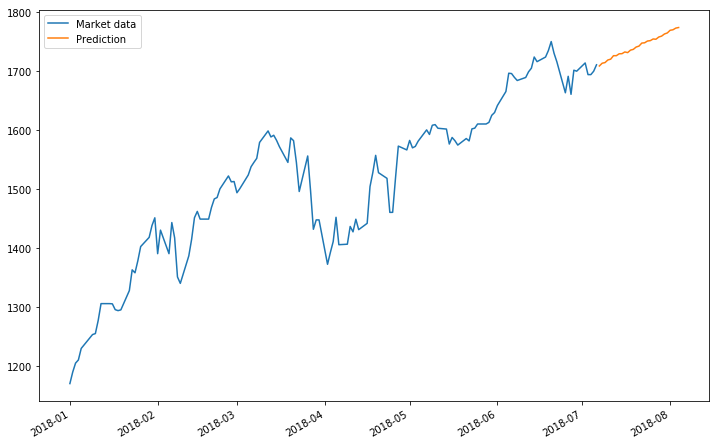

In [227]:
future_df[['Close', 'forecast']].loc['2018-01-01':].plot(figsize=(12, 8)) 
plt.legend(('Market data','Prediction' ))